# Aula sobre Agrupamento Hierárquico
#### UFRN
#### Pós-graduação Business Intelligence
#### Disciplina Ciência de Dados
#### Professor Leonardo
#### Alunos Gileno, Júlio, Thiago

> **Obs.:** Este exemplo, apesar de usado com dados extraídos pela própria equipe, baseou os passos no seguinte post:
> [A hierarchical clustering and dendrogram example using SciPy and pandas](http://datanongrata.com/2019/04/27/67/)
___
Primeiramente vamos aos imports necessários:

In [5]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from matplotlib.colors import rgb2hex, colorConverter
from scipy.cluster.hierarchy import set_link_color_palette
import pandas as pd
import scipy.cluster.hierarchy as sch
from pandas.plotting import scatter_matrix
%pylab inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 9

import seaborn as sns
sns.set_style("whitegrid")

Populating the interactive namespace from numpy and matplotlib


A primeira coisa é a leitura dos meus dados. 
Iremos utilizar a função de leitura de csv do pandas em cima do mesmo csv que explicamos na aula anterior. O arquivo contém a lista de estados brasileiros com algumas informações sobre os estados, quais sejam:

- Quantidade de processos eleitorais em tramitação nas zonas eleitorais;
- População;
- PIB;
- Quantidade de Entrada de Turistas no ano de 2018.


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/julincesar/arquivos-de-dados/master/processosTRE2d.csv', index_col=0)

Iremos fazer uma análise inicial sobre a relação entre a população e o PIB dos estados, pois foi a combinação em que ficou mais parecido com uma correlação entre as **features**.

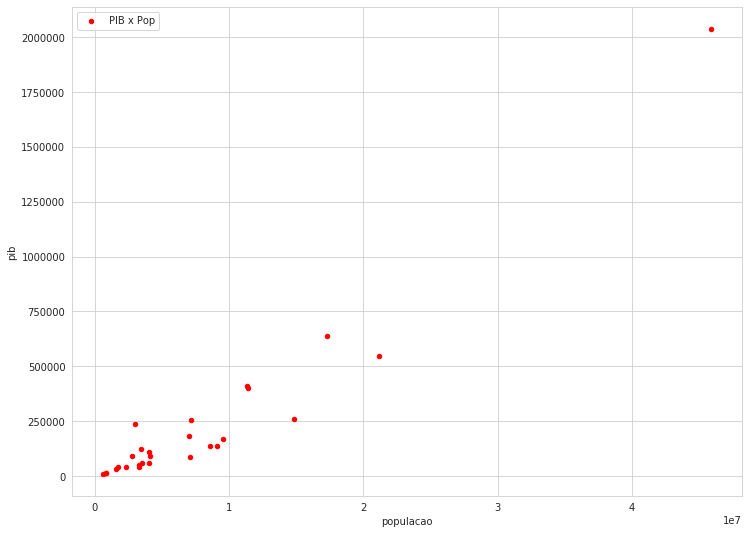

In [6]:
df.plot(kind='scatter',x='populacao',y='pib', color='Red', label='PIB x Pop') # scatter plot
plt.show()

De início podemos perceber o estado de São Paulo como outlier desse gráfico nas duas dimensões.
>*Quer dizer, dá pra supor. Queria aprender como faz pra cada ponto aparecer com uma cor diferente e as legendas aparecerem ao lado. Tem como?*

Fora isso, será que dá pra fazer um dendrograma interessante nesse gráfico?
Bora ver.



Precisamos decidir agrupar por linhas ou colunas. 
- Se o agrupamento for pelas colunas, pode usar o dataframe sem mexer. 
- Se for agrupar pelas linhas, tem que transpor o dataframe.

In [7]:
df_t=df.transpose()
print(df)

         populacao      pib
estados                    
SP        45919049  2038005
RJ        17264943   640186
MG        21168791   544634
RS        11377239   408645
PR        11433957   401662
BA        14873064   258649
SC         7164788   256661
DF         3015268   235497
GO         7018354   181692
PE         9557071   167290
CE         9132078   138379
PA         8602865   138068
MT         3484466   123834
ES         4018650   109227
MS         2778986    91866
AM         4144597    89017
MA         7075181    85286
RN         3506853    59661
PB         4018127    59089
AL         3337357    49456
PI         3273227    41406
RO         1777225    39451
SE         2298696    38867
TO         1572866    31576
AP          845731    14339
AC          881935    13751
RR          605761    11011


Para normalizar os dados, já que as dimensões dos atributos são bem discrepantes, então usamos o StandardScaler.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

Depois tem que calcular as matrizes de distância e de ligação, respectivamente, usando a biblioteca ScyPy.
> Consulte a documentação ScyPy para [pdist](https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.spatial.distance.pdist.html) e [linkage](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html), para maiores detalhes.

Neste caso, usamos o parâmetro default de cálculo de distância (Euclidiana). Equivale à L2-norm como métrica de distância entre os pontos. 
Uma vez que o objetivo do agrupamento é minimizar as distâncias entre os pontos do mesmo grupo, o propósito do algoritmo de ligação é calcular a distância entre os agrupamentos. 
Você pode escolher, por exemplo, a distância entre os centróides dos grupos ou a distância entre os pontos mais próximos em cada grupo.

Optamos pela opção "complete", que usa o algoritmo Voor Hees: d(u,v) = max(dist(u\[i\],v\[j\]))
Que é somente uma forma de dizer que ele calcula todas as distâncias entre os pontos do *cluster* u para o *cluster* v e pega a maior distância entre elas.

In [9]:
c_dist = pdist(df_t) # calculando as distâncias
c_link = linkage(c_dist,  metric='correlation', method='complete')# calculando a ligação entre os clusters

Com a matriz de ligação dá pra fazer um dendrograma. Percebam que as colunas originais do CSV são os rótulos do dendrograma. Dependendo dos parâmetros selecionados em pdist e linkage, o dendrograma será diferente.

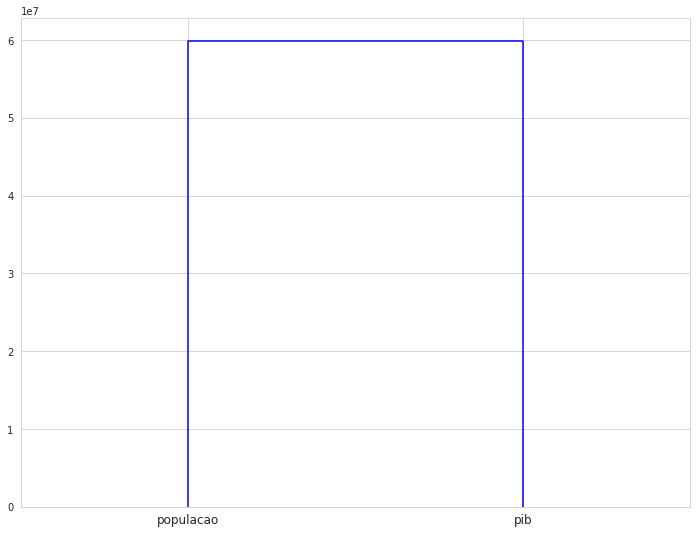

In [10]:
B=dendrogram(c_link,labels=list(df.columns))

Criamos uma classe Clusters que dá uma representação em HTML das associações dos grupos, bem como uma função para pegar essas associações e retornar uma legenda mais visível que diz quais Estados estão em cada grupamento, cada um com uma cor diferente que o representa. O código fonte original foi copiado daqui: http://www.nxn.se/valent/extract-cluster-elements-by-color-in-python

In [11]:
class Clusters(dict):
    def _repr_html_(self):
        html = '<table style="border: 0;">'
        for c in self:
            hx = rgb2hex(colorConverter.to_rgb(c))
            html += '<tr style="border: 0;">' \
            '<td style="background-color: {0}; ' \
                       'border: 0;">' \
            '<code style="background-color: {0};">'.format(hx)
            html += c + '</code></td>'
            html += '<td style="border: 0"><code>' 
            html += repr(self[c]) + '</code>'
            html += '</td></tr>'

        html += '</table>'

        return html
def get_cluster_classes(den, label='ivl'):
    cluster_idxs = defaultdict(list)
    for c, pi in zip(den['color_list'], den['icoord']):
        for leg in pi[1:3]:
            i = (leg - 5.0) / 10.0
            if abs(i - int(i)) < 1e-5:
                cluster_idxs[c].append(int(i))
    
    cluster_classes = Clusters()
    for c, l in cluster_idxs.items():
        i_l = [den[label][i] for i in l]
        cluster_classes[c] = i_l
    
    return cluster_classes

Peguei emprestado de um outro post uma extensão do dendrograma que mostra as distâncias entre os clusters e também traça a **linha de corte** para seleção dos grupamentos. [SciPy Hierarchical Clustering and Dendrogram Tutorial](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/)

In [37]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)
    
    ax = kwargs.pop('ax', plt.gca())

    if not kwargs.get('no_plot', False):
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                ax.plot(x, y, 'o', c=c)
                ax.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            ax.axhline(y=max_d, c='k')
    return ddata

Para simplificar, definimos uma função que empacota os passos:
- transposição da matriz;
- o cálculo da distância;
- o cálculo da ligação entre os grupos;
- a apresentação do dendrograma.

A função recebe como entrada obrigatória:
- um dataframe pandas.
- o número de clusters desejados;

E retorna um dendrograma como saída.

Os outros seis argumentos opcionais são:
- max_d é a distância de corte para selecionar os agrupamentos;
- annotate_above é o limiar de distância mínima para que ele comece a exibir a distância no dendrograma;
- transpor (true para linhas ou false para as colunas);
- scale (true para normalizar a escala de distância);
- dataname, que recebe uma string que descreve os dados e vai no título do dendrograma;
- Save indica se você quer que salve o gráfico como uma figura em PNG;
- Xticksize configura o número de ticks no eixo x, importante para legilibilidade.


In [53]:
def get_linkage(df, transpose=False, scale=False):
    if scale==True:
        scaler.fit(df)
        aml = scaler.transform(df)
    else:
        aml = df
    
    if transpose==True:
        aml=aml.transpose()

    data_dist = pdist(aml.transpose()) # computing the distance
    return linkage(data_dist,  metric='correlation', method='complete')#method="complete") # computing the linkage

def get_clust_graph(df, numclust, max_d=None, annotate_above=0, transpose=False, scale=False, dataname=None, save=False, xticksize=8):
    data_link = get_linkage(df, transpose=transpose, scale=scale)
    if transpose==True:
        xl="linhas"
        rotulos=df.transpose().columns
    else:
        xl="colunas"
        rotulos=df.columns
    
    #Criando dois axes, um para o dendograma e o outro para o gráfico de dispersão
    fig, (ax1, ax2) = plt.subplots(2)
    
    B=fancy_dendrogram(
        data_link,
        labels=list(rotulos),
        p=numclust, 
        truncate_mode="lastp",
        get_leaves=True, 
        count_sort='ascending', 
        show_contracted=True,
        annotate_above=annotate_above,
        max_d=max_d,
        ax=ax1)
    get_cluster_classes(B)
    ax1.set(title="Agrupamento em " + xl +" para "+dataname, ylabel='Distância', xlabel=xl)
    ax1.tick_params(axis='x', which='major', labelsize=xticksize)
    ax1.tick_params(axis='y', which='major', labelsize=15)
    
    from scipy.cluster.hierarchy import fcluster
    clusters = fcluster(data_link, max_d, criterion='distance')
    df.plot(kind='scatter',x='populacao',y='pib', c=clusters, colormap='Dark2', ax=ax2) # scatter plot
    
    if save:
        plt.savefig(str(df.index.name)+str(numclust)+"tr_"+str(transpose)+"dn_"+str(dataname)+save+'.png')
    else:
        print("Sem gravação de imagem.")
    return get_cluster_classes(B)

Vamos tentar com todos os Estados:

Sem gravação de imagem.


g,"['RJ', 'MG']"
r,"['RS', 'PR', 'BA', 'SC', 'GO', 'CE', 'PA', 'PE', 'MA']"
c,"['AP', 'AC', 'RR', 'RO', 'TO', 'SE', 'AL', 'PI', 'RN', 'PB', 'ES', 'AM', 'MT', 'MS', 'DF']"
b,['SP']


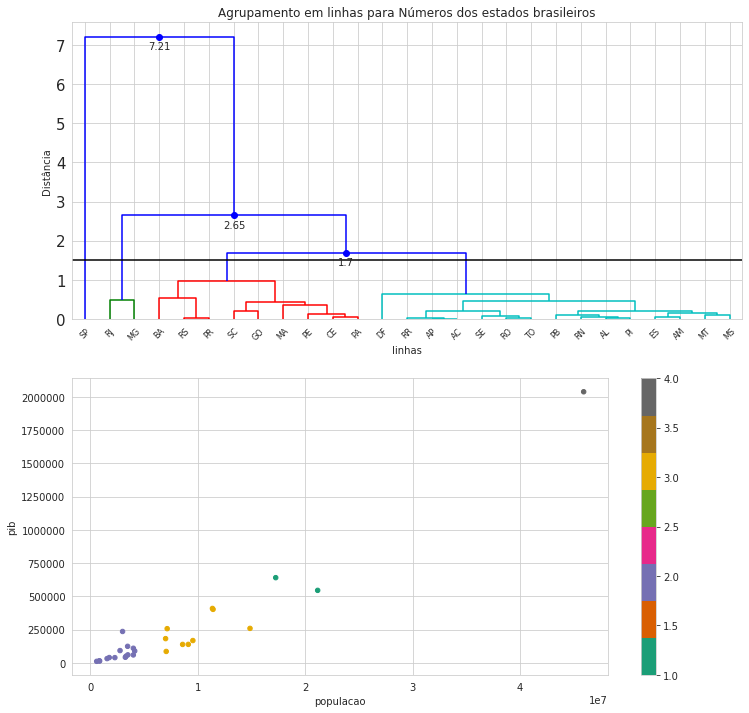

In [54]:
max_d=1.5
scale=True
transpose=True
get_clust_graph(df, 27, max_d=max_d, annotate_above=1, transpose=transpose, scale=scale,dataname="Números dos estados brasileiros")

Como percebemos, desde a visualização no início do gráfico de dispersão, SP ficou bem isolado como outlier, logo seguido do RJ e MG como grandes estados em população e PIB. 